In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
cur_path = "./drive/Othercomputers/Vivian's MacBook Pro 2021/DS5720/FinalProject"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/Othercomputers/Vivian's MacBook Pro 2021/DS5720/FinalProject


In [3]:
! pip install dgl
! pip uninstall umap
! pip install umap-learn
import dgl
import torch
import pandas as pd 
import umap.umap_ as umap

     |████████████████████████████████| 4.4 MB 4.3 MB/s 
     |████████████████████████████████| 88 kB 3.5 MB/s 
     |████████████████████████████████| 1.1 MB 24.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7355c6e4e1a5f602c8ff4b8c1ffd1d16742e6919e419a4c09acb2dcbd0469950
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=12dd9937e64acb46e0746d7908368cc45000ce789b9a0897408c75decb505737
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
reducer = umap.UMAP()

# 1. Data Import

In [4]:
task = pd.read_csv("./data/task2/train-v0.2.csv")
mega_table = pd.read_csv("./data/product_catalogue-v0.2.csv")
merged_df = pd.merge(task, mega_table, how = 'left', left_on = ['product_id', 'query_locale'], right_on = ['product_id', 'product_locale'])
# query_embed = pd.read_csv("./data/us50k_query_embedding.csv")
# product_title_embed = pd.read_csv("./data/us50k_product_title_embedding.csv")

In [5]:
merged_df = merged_df[merged_df['product_locale'] == 'us']
merged_df = merged_df.fillna('')

## 1.1 Get nodes

In [6]:
query_embed = pd.read_csv("./data/query_88d_embedding.csv")
query_embed = pd.merge(query_embed, pd.DataFrame(merged_df['query'].unique(), columns=['Query']), on = 'Query')
query_embed.insert(0, 'query_id', range(0, 0 + len(query_embed)))
query_embed['combined']=query_embed.drop(columns=['query_id', 'Query']).values.tolist()
query_embed = query_embed[['query_id', 'Query', 'combined']]
query_embed

,query_id,Query,combined
0,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87..."
1,1,# 2 pencils not sharpened,"[19.398371324702136, 4.7386912652123625, 0.152..."
2,2,# do not disturb,"[19.078527339962307, 4.277098531521469, -0.785..."
3,3,# mom life,"[-5.775765065166072, 1.2687145926624706, -2.55..."
4,4,# sharp not hashtag shirt,"[15.151273246281065, 1.5357711704597623, -1.36..."
...,...,...,...
68134,68134,tach adapter,"[-3.378503751095054, -1.3066904223212252, 1.34..."
68135,68135,the armorer vintage collection,"[-5.44916096928764, 1.8461803490483888, -0.324..."
68136,68136,trojan magnum condoms for men,"[3.833861734968945, -2.2165069732520517, -0.93..."
68137,68137,white adirondack chairs,"[-1.5253085263156851, -0.8573476160719742, 0.2..."


In [7]:
product_title_embed = pd.read_csv("./data/product_88d_embedding.csv")
# product_title_embed = product_title_embed[:857004]
merged_df['product'] = merged_df['product_title'] +  merged_df['product_description'] +  merged_df['product_bullet_point'] +  merged_df['product_brand'] +  merged_df['product_color_name']
product_title_embed = pd.merge(product_title_embed, pd.DataFrame(merged_df['product'].unique(), columns=['Product']), on = 'Product')
product_title_embed.insert(0, 'product_id', range(0, 0 + len(product_title_embed)))
product_title_embed['combined']=product_title_embed.drop(columns=['product_id', 'Product']).values.tolist()
product_title_embed = product_title_embed[['product_id', 'Product', 'combined']]
product_title_embed

,product_id,Product,combined
0,0,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,"[-4.361595723502376, 0.9364387358669418, -0.63..."
1,1,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...","[-4.179065625209809, 0.471360105629001, -0.715..."
2,2,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,"[-2.8169267146903616, -1.1865155362619637, -0...."
3,3,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,"[13.84494645659871, 4.88867980213354, -2.33215..."
4,4,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,"[-1.6226850900844525, -1.629046474344177, -0.7..."
...,...,...,...
856997,856997,VY4AOS2 My Hero Academia That Wasn't Very Plus...,"[12.097629648495747, 2.7960729345119284, 1.175..."
856998,856998,Phoetya Women's My Hero Academia Hoodie That's...,"[15.60419244951624, 8.029572555596365, 0.66361..."
856999,856999,Defrosting Tray (Largest Size) for Rapid thaw ...,"[-3.527773138502794, 0.3512122295462834, -0.45..."
857000,857000,Danoib Fast Defrosting Tray Rapid Thaw Plate M...,"[-3.0487363856102108, -0.232905261681144, -0.4..."


## 1.2 Get edges

In [8]:
cleaned_df = merged_df[merged_df['product_locale'] == 'us'][['query', 'product', 'esci_label']]
temp_merged = pd.merge(cleaned_df, query_embed, left_on = ['query'], right_on = ['Query'], how = 'left')
total_index = pd.merge(temp_merged, product_title_embed, left_on = ['product'], right_on = ['Product'], how = 'left', suffixes = ('_query', '_product') )
total_index = total_index.dropna()
# total_index
query_idx = total_index[['query_id', 'query', 'combined_query', 'esci_label']]
product_idx = total_index[['product_id', 'product', 'combined_product', 'esci_label']]
total_index

,query,product,esci_label,query_id,Query,combined_query,product_id,Product,combined_product
0,revent 80 cfm,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,irrelevant,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87...",0.0,Panasonic FV-20VQ3 WhisperCeiling 190 CFM Ceil...,"[-4.361595723502376, 0.9364387358669418, -0.63..."
1,revent 80 cfm,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...",exact,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87...",1.0,"Broan Very Quiet Ceiling Bathroom Exhaust Fan,...","[-4.179065625209809, 0.471360105629001, -0.715..."
2,revent 80 cfm,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,exact,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87...",2.0,Delta BreezSignature VFB25ACH 80 CFM Exhaust B...,"[-2.8169267146903616, -1.1865155362619637, -0...."
3,revent 80 cfm,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,exact,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87...",3.0,Aero Pure AP80RVLW Super Quiet 80 CFM Recessed...,"[13.84494645659871, 4.88867980213354, -2.33215..."
4,revent 80 cfm,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,exact,0,revent 80 cfm,"[6.707994892386412, -1.1259202660754608, -1.87...",4.0,Panasonic FV-0811VF5 WhisperFit EZ Retrofit Ve...,"[-1.6226850900844525, -1.629046474344177, -0.7..."
...,...,...,...,...,...,...,...,...,...
1272621,zephyr polishing kit,Buffing Wheel Rake Remove Residual Compounds/M...,irrelevant,68138,zephyr polishing kit,"[-3.797512703650293, -1.3904562297866971, 0.83...",766998.0,Buffing Wheel Rake Remove Residual Compounds/M...,"[-0.697468466278092, -1.3145220845254135, -0.2..."
1272622,zephyr polishing kit,Zephyr Orange Ruffy Heavy Cut Clear Dip Airway...,complement,68138,zephyr polishing kit,"[-3.797512703650293, -1.3904562297866971, 0.83...",766999.0,Zephyr Orange Ruffy Heavy Cut Clear Dip Airway...,"[8.05669257171573, -1.8337681391569216, -0.647..."
1272623,zephyr polishing kit,7 Inch Polishing Pads Kit Car Foam Sponge Pads...,substitute,68138,zephyr polishing kit,"[-3.797512703650293, -1.3904562297866971, 0.83...",804146.0,7 Inch Polishing Pads Kit Car Foam Sponge Pads...,"[-2.720129723442238, -0.4235162043279317, 0.32..."
1272624,zephyr polishing kit,"Kshineni Car Foam Drill 3-Inch Buffing Pad,11 ...",substitute,68138,zephyr polishing kit,"[-3.797512703650293, -1.3904562297866971, 0.83...",767000.0,"Kshineni Car Foam Drill 3-Inch Buffing Pad,11 ...","[0.1792142899080548, -2.1200385937646584, -0.3..."


In [9]:
i_edge_q = query_idx[query_idx['esci_label'] == 'irrelevant']
i_edge_p = product_idx[product_idx['esci_label'] == 'irrelevant']
i_edge_idx = [i_edge_q['query_id'].tolist(), i_edge_p['product_id'].tolist()]

e_edge_q = query_idx[query_idx['esci_label'] == 'exact']
e_edge_p = product_idx[product_idx['esci_label'] == 'exact']
e_edge_idx = [e_edge_q['query_id'].tolist(), e_edge_p['product_id'].tolist()]

c_edge_q = query_idx[query_idx['esci_label'] == 'complement']
c_edge_p = product_idx[product_idx['esci_label'] == 'complement']
c_edge_idx = [c_edge_q['query_id'].tolist(), c_edge_p['product_id'].tolist()]


s_edge_q = query_idx[query_idx['esci_label'] == 'substitute']
s_edge_p = product_idx[product_idx['esci_label'] == 'substitute']
s_edge_idx = [s_edge_q['query_id'].tolist(), s_edge_p['product_id'].tolist()]


# 2. Create Graph

In [10]:
graph_data = {
   ('query', 'irrelevant', 'product'): (torch.tensor(i_edge_idx[0], dtype=torch.int32), torch.tensor(i_edge_idx[1], dtype=torch.int32)),
   ('query', 'exact', 'product'): (torch.tensor(e_edge_idx[0], dtype=torch.int32), torch.tensor(e_edge_idx[1], dtype=torch.int32)),
   ('query', 'complement', 'product'): (torch.tensor(c_edge_idx[0], dtype=torch.int32), torch.tensor(c_edge_idx[1], dtype=torch.int32)),
   ('query', 'substitute', 'product'): (torch.tensor(s_edge_idx[0], dtype=torch.int32), torch.tensor(s_edge_idx[1], dtype=torch.int32))
}
qp_graph = dgl.heterograph(graph_data)

In [11]:
qp_graph

Graph(num_nodes={'product': 857002, 'query': 68139},
      num_edges={('query', 'complement', 'product'): 26648, ('query', 'exact', 'product'): 823409, ('query', 'irrelevant', 'product'): 107121, ('query', 'substitute', 'product'): 243782},
      metagraph=[('query', 'product', 'complement'), ('query', 'product', 'exact'), ('query', 'product', 'irrelevant'), ('query', 'product', 'substitute')])

In [12]:
qp_graph.nodes['query'].data['embed'] = torch.tensor(query_embed['combined'].tolist())
qp_graph.nodes['product'].data['embed'] = torch.tensor(product_title_embed['combined'].tolist())

In [13]:
import gc

del task
del mega_table
del merged_df
del cleaned_df

gc.collect()

238

# 3. Train a model

In [14]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['embed'], edges.dst['embed']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        return self.pred(dec_graph, h)

In [15]:
dec_graph = qp_graph['query', :, 'product']
edge_label = torch.tensor(dec_graph.edata[dgl.ETYPE], dtype=torch.long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [16]:
dec_graph.edata['train_mask'] = torch.zeros(dec_graph.num_edges('complement+exact+irrelevant+substitute'), dtype=torch.bool).bernoulli(0.7)
dec_graph.edata['val_mask'] = torch.tensor([not x for x in dec_graph.edata['train_mask'] ], dtype=torch.bool)

In [17]:
train_mask = dec_graph.edata['train_mask']
val_mask = dec_graph.edata['val_mask']

In [18]:
! pip install torchmetrics

     |████████████████████████████████| 409 kB 4.2 MB/s 


In [19]:
from torchmetrics import F1Score, Accuracy

model = Model(88, 176, 88, qp_graph.etypes)
query_feats = qp_graph.nodes['query'].data['embed']
product_feats = qp_graph.nodes['product'].data['embed']
node_features = {'query': query_feats, 'product': product_feats}

acc_list = []
f1_w = []
f1_m = []

opt = torch.optim.Adam(model.parameters(), lr=0.001)
for epoch in range(2000):
    model.train()
    logits = model(qp_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(f"Epoch: {epoch}, Training Loss = {loss.item()}")

    if epoch % 10 == 0:
      model.eval()
      with torch.no_grad():
          logits = model(qp_graph, node_features, dec_graph)
          logits = logits[val_mask]
          labels = edge_label[val_mask]
          _, indices = torch.max(logits, dim=1)
          correct = torch.sum(indices == labels)
          f1 = F1Score(num_classes=4, average = 'weighted')
          f1_weighted = f1(indices, labels)
          f1 = F1Score(num_classes=4, average = 'macro')
          f1_macro = f1(indices, labels)
          accuracy = Accuracy()
          acc = accuracy(indices, labels)
          acc_list.append(acc.item())
          f1_w.append(f1_weighted.item())
          f1_m.append(f1_macro.item())
          print("Accuracy = ", acc.item(), "F1 weighted = ", f1_weighted.item(), "F1 macro = ", f1_macro.item())

Epoch: 0, Training Loss = 1.5377602577209473
Accuracy =  0.24428123235702515 F1 weighted =  0.3111568093299866 F1 macro =  0.1803833395242691
Epoch: 1, Training Loss = 1.5312258005142212
Epoch: 2, Training Loss = 1.5247867107391357
Epoch: 3, Training Loss = 1.5184451341629028
Epoch: 4, Training Loss = 1.5122032165527344
Epoch: 5, Training Loss = 1.506062626838684
Epoch: 6, Training Loss = 1.5000258684158325
Epoch: 7, Training Loss = 1.4940941333770752
Epoch: 8, Training Loss = 1.4882686138153076
Epoch: 9, Training Loss = 1.4825509786605835
Epoch: 10, Training Loss = 1.4769412279129028
Accuracy =  0.26876404881477356 F1 weighted =  0.33717453479766846 F1 macro =  0.19303807616233826
Epoch: 11, Training Loss = 1.4714409112930298
Epoch: 12, Training Loss = 1.466049075126648
Epoch: 13, Training Loss = 1.4607667922973633
Epoch: 14, Training Loss = 1.4555938243865967
Epoch: 15, Training Loss = 1.4505305290222168
Epoch: 16, Training Loss = 1.4455764293670654
Epoch: 17, Training Loss = 1.44073

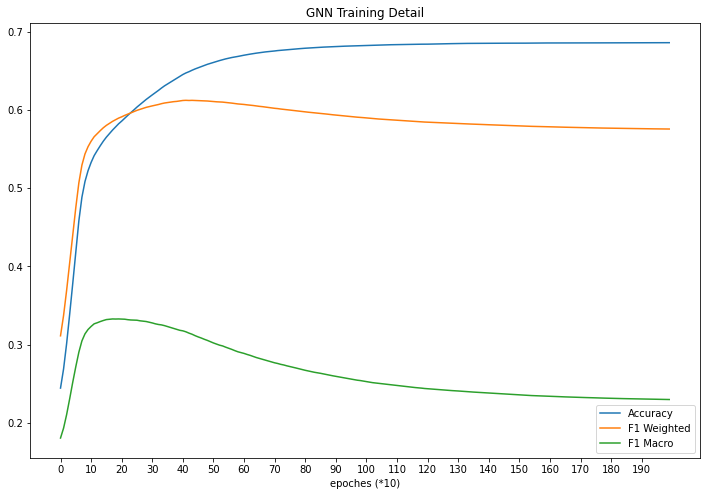

In [25]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(list(range(200)), acc_list, label="Accuracy")
plt.plot(list(range(200)), f1_w, label="F1 Weighted")
plt.plot(list(range(200)), f1_m, label="F1 Macro")
plt.legend(loc="lower right")
plt.title("GNN Training Detail")
plt.xlabel("epoches (*10)")
plt.xticks(np.arange(0, 200, 10))
plt.show()